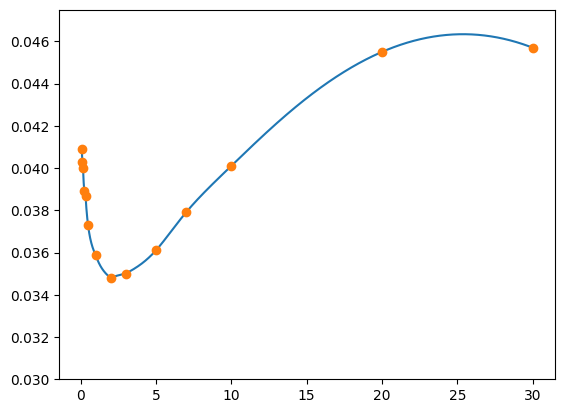

In [15]:
import numpy as np
from scipy.interpolate import CubicSpline
from gfuncpy import Identity, gfunc
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta 
from math import exp
from typing import List

#-----------------ONE: Curve Interpolation---------------
T_knots = np.array([1/12, 1.5/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
R = np.array([4.09, 4.03, 4, 3.89, 3.87, 3.73, 3.59, 3.48, 3.5, 3.61, 3.79, 4.01, 4.55, 4.57])/100

yield_curve_spline = CubicSpline(T_knots, T_knots*R)

@gfunc
def TR(x):
    if x<3:
        return np.interp(x, T_knots, T_knots*R)
    else:
        return yield_curve_spline(x)
    
T = Identity([min(T_knots),30])
(TR(T)/T).plot()
plt.plot(T_knots, R, 'o')
plt.ylim(0.03, 0.0475)
plt.show()


In [16]:

#----------------TWO: Portfolio Delta Ladder----------------------

tlt = pd.read_csv("/Users/yuxincao/PCA-Hedge/data/TLT_holdings_10272025_cleaned.csv")
tlt["Maturity"] = pd.to_datetime(tlt["Maturity"])
tlt["Coupon"] = tlt["Coupon (%)"] / 100.0
tlt["Notional"] = tlt["Notional Value"]


#Compute all coupon dates
def year_frac(d0: date, d1: date) -> float:
    return max((d1-d0).days, 0) / 365.0

def coupon_schedule(maturity: date, settlement: date) -> List [date]:
    if maturity <= settlement:
        return []

    dates = [maturity]
    d = maturity

    while True:
        d = d - relativedelta(months=6)
        if d <= settlement:
            break
        dates.append(d)

    return list(reversed(dates))

#Compute PV(clean price)
def y_from_TR(t: float) -> float:
    t_eff = max(t, 1e-10)
    return TR(t_eff)/ t_eff

def discount_factor(t: float) -> float:
    y = y_from_TR(t)
    return np.exp(-y * t)

def bond_price_clean_row(row, settlement: date) -> float:
    maturity = row["Maturity"].date()
    coupon = float(row["Coupon"])
    notional = float(row["Notional"])

    c_dates = coupon_schedule(maturity, settlement)
    if not c_dates:
        return 0.0
    
    coupon_payment = coupon * notional / 2
    pv = 0.0
    n = len(c_dates)

    for i, dt in enumerate(c_dates, 1):
        t = year_frac(settlement, dt)
        df = discount_factor(t)
        cash = coupon_payment + (notional if i == n else 0.0)
        pv += cash * df
    
    return pv

#Compute portfolio Delta ladder
def portfolio_pv(df: pd.DataFrame, settlement: date) -> float:
    total_pv = 0.0
    for index, row_data in df.iterrows():
        bond_price = bond_price_clean_row(row_data, settlement)
        total_pv += bond_price
    return total_pv


settlement = date(2025, 10, 27)
Bump_bp = 1e-4  #+1bp

R_base = R. copy()
yield_curve_spline_base = yield_curve_spline
pv_base = portfolio_pv(tlt, settlement)

ladder = []
for k in range(len(T_knots)):
    old_rate = R[k]
    R[k] = old_rate + Bump_bp
    yield_curve_spline = CubicSpline(T_knots, T_knots * R)
    pv_bump = portfolio_pv(tlt, settlement)
    
    R[k] = old_rate
    yield_curve_spline = yield_curve_spline_base

    dPV_dy = (pv_bump - pv_base) / Bump_bp

    ladder.append({
        "Maturity(yr)": T_knots[k],
        "BaseRate(%)": R_base[k] * 100,
        "PV_base": pv_base,
        "PV_bump": pv_bump,
        "DollarDelta": dPV_dy })
    
ladder_df = pd.DataFrame(ladder).sort_values("Maturity(yr)").reset_index(drop=True)
print(ladder_df)


    Maturity(yr)  BaseRate(%)       PV_base       PV_bump   DollarDelta
0       0.083333         4.09  4.159595e+10  4.159594e+10 -3.380841e+07
1       0.125000         4.03  4.159595e+10  4.159595e+10  3.436027e+06
2       0.166667         4.00  4.159595e+10  4.159595e+10 -1.088075e+07
3       0.250000         3.89  4.159595e+10  4.159595e+10  9.792280e+06
4       0.333333         3.87  4.159595e+10  4.159593e+10 -2.114609e+08
5       0.500000         3.73  4.159595e+10  4.159594e+10 -5.526161e+07
6       1.000000         3.59  4.159595e+10  4.159578e+10 -1.639963e+09
7       2.000000         3.48  4.159595e+10  4.159587e+10 -7.549337e+08
8       3.000000         3.50  4.159595e+10  4.159482e+10 -1.122355e+10
9       5.000000         3.61  4.159595e+10  4.159613e+10  1.788097e+09
10      7.000000         3.79  4.159595e+10  4.158854e+10 -7.403417e+10
11     10.000000         4.01  4.159595e+10  4.159851e+10  2.566597e+10
12     20.000000         4.55  4.159595e+10  4.155603e+10 -3.992

PC1 explains 76.01% of total variance 
PC2 explains 9.93% of total variance 
PC3 explains 5.67% of total variance 


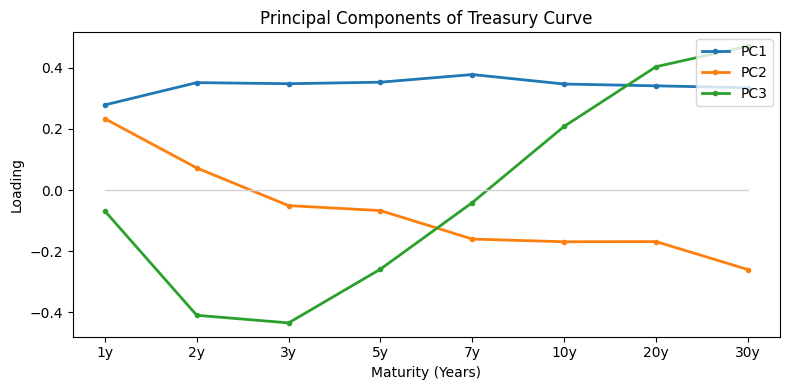


Score variance by component:
                PC1           PC2           PC3           PC4           PC5           PC6           PC7           PC8           PC9          PC10          PC11          PC12          PC13          PC14
Score Var  0.000001  1.346950e-07  7.684315e-08  3.157555e-08  2.013041e-08  1.862973e-08  1.116984e-08  1.043401e-08  7.798291e-09  5.605050e-09  4.234976e-09  1.921707e-09  1.476131e-09  7.633615e-10


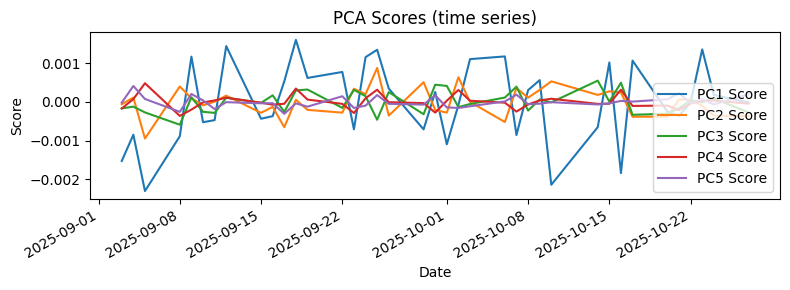

In [1]:

#Curve PCA and Hedge
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

curve_df = pd.read_csv("/Users/yuxincao/PCA-Hedge/data/treasury_yield_09022025-10272025.csv")
curve_df.columns = curve_df.columns.str.strip()                        
curve_df['Date'] = pd.to_datetime(curve_df['Date']).dt.normalize()     
curve_df = curve_df.set_index('Date')

R_panel = curve_df / 100.0
dR = R_panel.diff().dropna()

pca = PCA()
pca.fit(dR)


PCs = pca.components_
explained = pca.explained_variance_ratio_
scores = pca.transform(dR)

for i, var in enumerate(explained[:3], start=1):
    print(f"PC{i} explains {var:.2%} of total variance ")

year_labels = ['1 Mo', '1.5 Mo', '2 Mo', '3 Mo', '4 Mo', '6 Mo', 
                '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']

n = 3
idx_years = [6, 7, 8, 9, 10, 11, 12, 13]
x_labels  = ['1y', '2y', '3y', '5y', '7y', '10y', '20y', '30y']

v = PCs[:n, idx_years].T


fig, ax = plt.subplots(figsize=(8, 4))
ax = pd.DataFrame(v, columns=[f'PC{j}' for j in range(1, n+1)],index=x_labels).plot(style='.-', ax=ax, linewidth=2)

ax.plot(range(len(x_labels)), np.zeros(len(x_labels)), color='lightgray', linewidth=1)
ax.set_title("Principal Components of Treasury Curve")
ax.set_xlabel("Maturity (Years)")
ax.set_ylabel("Loading")
ax.legend(frameon=True, loc='upper right')
plt.tight_layout()
plt.show()

scores_df = pd.DataFrame(scores, index=dR.index, columns=[f"PC{i}" for i in range(1, PCs.shape[0]+1)])
score_var = (scores_df**2).mean().to_frame(name='Score Var').T
print("\nScore variance by component:")
print(score_var.to_string())

k = min(5, scores_df.shape[1])
fig, ax = plt.subplots(figsize=(8, 3))
scores_df.iloc[:, :k].rename(columns=lambda c: f"{c} Score").plot(ax=ax)
ax.set_title("PCA Scores (time series)")
ax.set_xlabel("Date")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()



In [ ]:
# Hedge out PC1

#------Compute the Delta ladder of a 10y ZCB as of 10/27/2025---------
portfolio_ladder = ladder_df.sort_values("Maturity(yr)")["DollarDelta"].to_numpy(float)
PC1 = PCs[0]

#Compute the 10Y ZCB Delta Ladder (Closed Form)
tenor_10y = 10.0
y_10y_1027 = float(curve_df.loc['2025-10-27', '10 Yr']) / 100.0
P_10y_1027 = np.exp(-y_10y_1027 * tenor_10y)

ladder_10y_unit = np.zeros(len(year_labels))
idx_10y = year_labels.index('10 Yr')
ladder_10y_unit[idx_10y] = (-tenor_10y * P_10y_1027) * 1e-4

expo_port_PC1 = float(portfolio_ladder @ PC1)
expo_10y_PC1_unit = float(ladder_10y_unit @ PC1)

N_hedge_10y = - expo_port_PC1 / expo_10y_PC1_unit
print(f"Hedge notional of 10Y ZCB (unit face): {N_hedge_10y:.4f}")

ladder_after = portfolio_ladder + N_hedge_10y * ladder_10y_unit

ladder_compare = pd.DataFrame([portfolio_ladder, N_hedge_10y * ladder_10y_unit, ladder_after], 
    index=['Before Hedge', f'Hedge 10Y ZCB (N={N_hedge_10y:.2f})', 'After Hedge'],
    columns=year_labels).round(4)

print("\n--- Dollar Delta Ladder ($/bp) ---")
print(ladder_compare.to_string())



extra_1028 = pd.read_csv("/Users/yuxincao/PCA-Hedge/data/treasury_10-28-2025.csv")
extra_1028.columns = extra_1028.columns.str.strip()
extra_1028['Date'] = pd.to_datetime(extra_1028['Date']).dt.normalize()
extra_1028 = extra_1028.set_index('Date')
curve_df_pnl = pd.concat([curve_df, extra_1028[year_labels]], axis=0).sort_index()

#-------------Compute PnL on 2025-10-28------------
def load_curve(curve_date: str):
    global R, yield_curve_spline
    dt = pd.to_datetime(curve_date).normalize()
    if dt not in curve_df_pnl.index:
        raise KeyError(
            f"Curve for {dt.date()} not found. Available: "
            f"{curve_df_pnl.index.min().date()} → {curve_df_pnl.index.max().date()}"
        )
    rates = curve_df_pnl.loc[dt, year_labels].to_numpy(float) / 100.0
    R = rates
    yield_curve_spline = CubicSpline(T_knots, T_knots * R)


load_curve('2025-10-27'); pv_27 = float(portfolio_pv(tlt, date(2025, 10, 27)))
load_curve('2025-10-28'); pv_28 = float(portfolio_pv(tlt, date(2025, 10, 28)))

load_curve('2025-10-28')
pv_28 = float(portfolio_pv(tlt, date(2025, 10, 28)))

load_curve('2025-10-27'); pv_27 = float(portfolio_pv(tlt, date(2025, 10, 27)))
load_curve('2025-10-28'); pv_28 = float(portfolio_pv(tlt, date(2025, 10, 28)))


T10 = 10.0
y27 = float(curve_df_pnl.loc['2025-10-27', '10 Yr']) / 100.0
y28 = float(curve_df_pnl.loc['2025-10-28', '10 Yr']) / 100.0
P27 = np.exp(-y27 * T10)
P28 = np.exp(-y28 * T10)
pnl_nohedge = pv_28 - pv_27
pnl_hedged  = (pv_28 + N_hedge_10y * P28) - (pv_27 + N_hedge_10y * P27)

print("\n--- Portfolio PnL (2025-10-27 → 2025-10-28) ---")
print(f"No Hedge       : {pnl_nohedge:,.2f} USD")
print(f"With 10Y Hedge : {pnl_hedged:,.2f} USD")

Hedge notional of 10Y ZCB (unit face): -989481283162495.6250

--- Dollar Delta Ladder ($/bp) ---
                                               1 Mo        1.5 Mo          2 Mo          3 Mo          4 Mo          6 Mo          1 Yr          2 Yr          3 Yr          5 Yr          7 Yr         10 Yr         20 Yr         30 Yr
Before Hedge                          -3.380841e+07  3.436027e+06 -1.088075e+07  9.792280e+06 -2.114609e+08 -5.526161e+07 -1.639963e+09 -7.549337e+08 -1.122355e+10  1.788097e+09 -7.403417e+10  2.566597e+10 -3.992057e+11 -2.109403e+11
Hedge 10Y ZCB (N=-989481283162495.62) -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00  6.626062e+11 -0.000000e+00 -0.000000e+00
After Hedge                           -3.380841e+07  3.436027e+06 -1.088075e+07  9.792280e+06 -2.114609e+08 -5.526161e+07 -1.639963e+09 -7.549337e+08 -1.122355e+10  1.788097e+09 -7.403417e+10  6.882722

In [20]:
# Hedge out both PC1 and PC2
T_2y = 2.0
y_2y_1027 = float(curve_df.loc[pd.Timestamp('2025-10-27'), '2 Yr']) / 100.0   
P_2y_1027 = np.exp(-y_2y_1027 * T_2y)

ladder_2y_unit = np.zeros(len(year_labels))
idx_2y = year_labels.index('2 Yr')

ladder_2y_unit[idx_2y] = (-T_2y * P_2y_1027) * 1e-4
ladder_2y_df = pd.DataFrame(ladder_2y_unit.reshape(1,-1), columns=year_labels, index=['2Y ZCB (unit face)'])
print("\n--- 2Y ZCB Dollar-Delta Ladder ($/bp) @ 2025-10-27 ---")
print(ladder_2y_df.round(6).to_string())


PC2 = PCs[1]
expo_port = np.array([float(portfolio_ladder @ PC1), float(portfolio_ladder @ PC2)])
E = np.array([[float(ladder_10y_unit @ PC1), float(ladder_2y_unit @ PC1)],[float(ladder_10y_unit @ PC2), float(ladder_2y_unit @ PC2)]])
N_10y_2y = -np.linalg.solve(E, expo_port)
N_10y_both, N_2y_both = float(N_10y_2y[0]), float(N_10y_2y[1])

print("\n--- Notionals to hedge PC1 & PC2 (unit face) ---")
print(f"N_10Y ZCB : {N_10y_both:,.6f}")
print(f"N_2Y  ZCB : {N_2y_both:,.6f}")


--- 2Y ZCB Dollar-Delta Ladder ($/bp) @ 2025-10-27 ---
                    1 Mo  1.5 Mo  2 Mo  3 Mo  4 Mo  6 Mo  1 Yr      2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr  30 Yr
2Y ZCB (unit face)   0.0     0.0   0.0   0.0   0.0   0.0   0.0 -0.000187   0.0   0.0   0.0    0.0    0.0    0.0

--- Notionals to hedge PC1 & PC2 (unit face) ---
N_10Y ZCB : -1,098,135,166,893,606.875000
N_2Y  ZCB : 384,909,787,685,765.000000


In [21]:
ladder_10y_pos   = N_10y_both * ladder_10y_unit
ladder_2y_pos    = N_2y_both  * ladder_2y_unit
ladder_after_both = portfolio_ladder + ladder_10y_pos + ladder_2y_pos
ladder_both_df = pd.DataFrame(
    [portfolio_ladder, ladder_10y_pos, ladder_2y_pos, ladder_after_both],
    index=['Before Hedge', f'Add 10Y ZCB (N={N_10y_both:.2f})', f'Add 2Y ZCB (N={N_2y_both:.2f})', 'After Hedge (10Y+2Y)'], columns=year_labels).round(4)
print("\n--- Dollar Delta Ladder ($/bp) ---")
print(ladder_both_df.to_string())


def pc_exposures(ladder_vec):
    return np.array([float(ladder_vec @ PCs[0]),
                     float(ladder_vec @ PCs[1]),
                     float(ladder_vec @ PCs[2])])

exp_before = pc_exposures(portfolio_ladder)
exp_after  = pc_exposures(ladder_after_both)

print("\nPC exposures ($/bp) [PC1, PC2, PC3]:")
print("Before:", np.round(exp_before, 4))
print("After :", np.round(exp_after,  4))


--- Dollar Delta Ladder ($/bp) ---
                                              1 Mo        1.5 Mo          2 Mo          3 Mo          4 Mo          6 Mo          1 Yr          2 Yr          3 Yr          5 Yr          7 Yr         10 Yr         20 Yr         30 Yr
Before Hedge                         -3.380841e+07  3.436027e+06 -1.088075e+07  9.792280e+06 -2.114609e+08 -5.526161e+07 -1.639963e+09 -7.549337e+08 -1.122355e+10  1.788097e+09 -7.403417e+10  2.566597e+10 -3.992057e+11 -2.109403e+11
Add 10Y ZCB (N=-1098135166893606.88) -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00  7.353663e+11 -0.000000e+00 -0.000000e+00
Add 2Y ZCB (N=384909787685765.00)     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -7.180622e+10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
After Hedge (10Y+2Y)            

In [25]:
# ---- append 2025-10-28 curve only for PnL ----
extra_1028 = pd.read_csv("/Users/yuxincao/PCA-Hedge/data/treasury_10-28-2025.csv")
extra_1028.columns = extra_1028.columns.str.strip()
extra_1028['Date'] = pd.to_datetime(extra_1028['Date']).dt.normalize()
extra_1028 = extra_1028.set_index('Date')

curve_df_pnl = pd.concat([curve_df, extra_1028[year_labels]], axis=0).sort_index()

assert pd.Timestamp('2025-10-28') in curve_df_pnl.index, \
    f"10/28/2025 not found. Available: {curve_df_pnl.index.min().date()} → {curve_df_pnl.index.max().date()}"


# --- Compute PnL with and without 10Y + 2Y Hedge (2025-10-27 → 2025-10-28) ---

def load_curve(curve_date: str):
    """Load a specific day's curve into R and yield_curve_spline (for PnL)"""
    global R, yield_curve_spline
    dt = pd.to_datetime(curve_date).normalize()
    if dt not in curve_df_pnl.index:
        raise KeyError(f"Curve {dt.date()} not found. "
                       f"Range: {curve_df_pnl.index.min().date()} → {curve_df_pnl.index.max().date()}")
    rates = curve_df_pnl.loc[dt, year_labels].to_numpy(float) / 100.0
    R = rates
    yield_curve_spline = CubicSpline(T_knots, T_knots * R)

# ---- Portfolio PVs on both days ----
load_curve('2025-10-27'); pv_27 = float(portfolio_pv(tlt, date(2025, 10, 27)))
load_curve('2025-10-28'); pv_28 = float(portfolio_pv(tlt, date(2025, 10, 28)))

# ---- 10Y & 2Y ZCB prices (closed-form) ----
T10, T2 = 10.0, 2.0
y10_27 = float(curve_df_pnl.loc[pd.Timestamp('2025-10-27'), '10 Yr']) / 100.0
y10_28 = float(curve_df_pnl.loc[pd.Timestamp('2025-10-28'), '10 Yr']) / 100.0
P10_27, P10_28 = np.exp(-y10_27 * T10), np.exp(-y10_28 * T10)

y2_27  = float(curve_df_pnl.loc[pd.Timestamp('2025-10-27'),  '2 Yr']) / 100.0
y2_28  = float(curve_df_pnl.loc[pd.Timestamp('2025-10-28'),  '2 Yr']) / 100.0
P2_27, P2_28 = np.exp(-y2_27  * T2),  np.exp(-y2_28  * T2)

# ---- PnL ----
pnl_nohedge = pv_28 - pv_27
pnl_hedged  = (pv_28 + N_10y_both * P10_28 + N_2y_both * P2_28) \
            - (pv_27 + N_10y_both * P10_27 + N_2y_both * P2_27)

print("\n--- Portfolio PnL (2025-10-27 → 2025-10-28) ---")
print(f"No Hedge            : {pnl_nohedge:,.2f} USD")
print(f"With 10Y + 2Y Hedge : {pnl_hedged:,.2f} USD")



--- Portfolio PnL (2025-10-27 → 2025-10-28) ---
No Hedge            : 137,130,026.95 USD
With 10Y + 2Y Hedge : -1,400,253,747,295.31 USD
